In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import networkx as nx
import matplotlib.pyplot as plt
import cv2 as cv
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import os

## Plotting the Layouts

### Using Class Object

In [2]:


# Dictionaries for room type to color and room class
ID_COLOR = {1: '#EE4D4D', 2: '#C67C7B', 3: '#FFD274', 4: '#BEBEBE', 5: '#BFE3E8',
            6: '#7BA779', 7: '#E87A90', 8: '#FF8C69', 10: '#1F849B', 11: '#727171',
            13: '#785A67', 12: '#D3A2C7', 17: '#FFA500'}

ROOM_CLASS = {'Living Room': 1, 'Kitchen': 2, 'Bedroom': 3, 'Bathroom': 4, 'Balcony': 5,
    'Entrance': 6, 'Dining Room': 7, 'Study Room': 8, 'Storage': 10, 'Front Door': 11,
    'Unknown': 13, 'Interior Door': 12, 'Door': 17}

ID_TO_ROOM_NAME = {v: k for k, v in ROOM_CLASS.items()}

class RoomLayout:
    def __init__(self, set_name='train'):
        self.set_name = set_name

    def reader(self, filename):
        with open(filename) as f:
            info = json.load(f)
            rms_bbs = np.asarray(info['boxes'])
            fp_eds = info['edges']
            rms_type = info['room_type']
            eds_to_rms = info['ed_rm']
            s_r = 0
            for rmk in range(len(rms_type)):
                if rms_type[rmk] != 17:
                    s_r = s_r + 1
            rms_bbs = np.array(rms_bbs) / 256.0
            fp_eds = np.array(fp_eds) / 256.0
            fp_eds = fp_eds[:, :4]
            tl = np.min(rms_bbs[:, :2], 0)
            br = np.max(rms_bbs[:, 2:], 0)
            shift = (tl + br) / 2.0 - 0.5
            rms_bbs[:, :2] -= shift
            rms_bbs[:, 2:] -= shift
            fp_eds[:, :2] -= shift
            fp_eds[:, 2:] -= shift
            tl -= shift
            br -= shift

        return rms_type, fp_eds, rms_bbs, eds_to_rms

    def plot_results(self, rms_type, fp_eds, rms_bbs, output_file='output.svg'):
        plt.figure(figsize=(10, 10))

        # Plot room bounding boxes and annotate with room names
        for idx, bbox in enumerate(rms_bbs):
            room_type_id = rms_type[idx]
            room_color = ID_COLOR.get(room_type_id, '#000000')  # Default to black if ID not found
            room_name = ID_TO_ROOM_NAME.get(room_type_id, 'Unknown')

            # Fill the room with the corresponding color
            plt.fill([bbox[0], bbox[2], bbox[2], bbox[0]], [bbox[1], bbox[1], bbox[3], bbox[3]], color=room_color, alpha=0.5)

            # Draw the bounding box
            plt.plot([bbox[0], bbox[2]], [bbox[1], bbox[1]], color='k')
            plt.plot([bbox[0], bbox[2]], [bbox[3], bbox[3]], color='k')
            plt.plot([bbox[0], bbox[0]], [bbox[1], bbox[3]], color='k')
            plt.plot([bbox[2], bbox[2]], [bbox[1], bbox[3]], color='k')

            # Annotate with room name
            plt.text((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2, room_name,
                     horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

        # Plot edges
        for edge in fp_eds:
            plt.plot([edge[0], edge[2]], [edge[1], edge[3]], 'r-')

        plt.grid(True)
        plt.axis('equal')
        
        # Save the plot as an SVG file
        plt.savefig(output_file, format='svg')
        plt.show()

    def build_graph(self, rms_type, fp_eds, eds_to_rms, out_size=64):
        # create edges
        triples = []
        nodes = rms_type
        # encode connections
        for k in range(len(nodes)):
            for l in range(len(nodes)):
                if l > k:
                    is_adjacent = any([True for e_map in eds_to_rms if (l in e_map) and (k in e_map)])
                    if is_adjacent:
                        if 'train' in self.set_name:
                            triples.append([k, 1, l])
                        else:
                            triples.append([k, 1, l])
                    else:
                        if 'train' in self.set_name:
                            triples.append([k, -1, l])
                        else:
                            triples.append([k, -1, l])
        # get rooms masks
        eds_to_rms_tmp = []
        for l in range(len(eds_to_rms)):
            eds_to_rms_tmp.append([eds_to_rms[l][0]])
        rms_masks = []
        im_size = 256
        fp_mk = np.zeros((out_size, out_size))
        for k in range(len(nodes)):
            # add rooms and doors
            eds = []
            for l, e_map in enumerate(eds_to_rms_tmp):
                if (k in e_map):
                    eds.append(l)
            # draw rooms
            rm_im = Image.new('L', (im_size, im_size))
            dr = ImageDraw.Draw(rm_im)
            for eds_poly in [eds]:
                poly = self.make_sequence(np.array([fp_eds[l][:4] for l in eds_poly]))[0]
                poly = [(im_size * x, im_size * y) for x, y in poly]
                if len(poly) >= 2:
                    dr.polygon(poly, fill='white')
                else:
                    print("Empty room")
                    exit(0)
            rm_im = rm_im.resize((out_size, out_size))
            rm_arr = np.array(rm_im)
            inds = np.where(rm_arr > 0)
            rm_arr[inds] = 1.0
            rms_masks.append(rm_arr)
            if rms_type[k] != 15 and rms_type[k] != 17:
                fp_mk[inds] = k + 1
        # trick to remove overlap
        for k in range(len(nodes)):
            if rms_type[k] != 15 and rms_type[k] != 17:
                rm_arr = np.zeros((out_size, out_size))
                inds = np.where(fp_mk == k + 1)
                rm_arr[inds] = 1.0
                rms_masks[k] = rm_arr
        # convert to array
        nodes = np.array(nodes)
        triples = np.array(triples)
        rms_masks = np.array(rms_masks)
        return nodes, triples, rms_masks

    def make_sequence(self, edges):
        polys = []
        v_curr = tuple(edges[0][:2])
        e_ind_curr = 0
        e_visited = [0]
        seq_tracker = [v_curr]

        find_next = False
        while len(e_visited) < len(edges):
            if not find_next:
                if v_curr == tuple(edges[e_ind_curr][2:]):
                    v_curr = tuple(edges[e_ind_curr][:2])
                else:
                    v_curr = tuple(edges[e_ind_curr][2:])
                find_next = not find_next
            else:
                # look for next edge
                for k, e in enumerate(edges):
                    if k not in e_visited:
                        if v_curr == tuple(e[:2]):
                            v_curr = tuple(e[2:])
                            e_ind_curr = k
                            e_visited.append(k)
                            break
                        elif v_curr == tuple(e[2:]):
                            v_curr = tuple(e[:2])
                            e_ind_curr = k
                            e_visited.append(k)
                            break

            # extract next sequence
            if v_curr == seq_tracker[-1]:
                polys.append(seq_tracker)
                for k, e in enumerate(edges):
                    if k not in e_visited:
                        v_curr = tuple(edges[0][:2])
                        seq_tracker = [v_curr]
                        find_next = False
                        e_ind_curr = k
                        e_visited.append(k)
                        break
            else:
                seq_tracker.append(v_curr)
        polys.append(seq_tracker)

        return polys




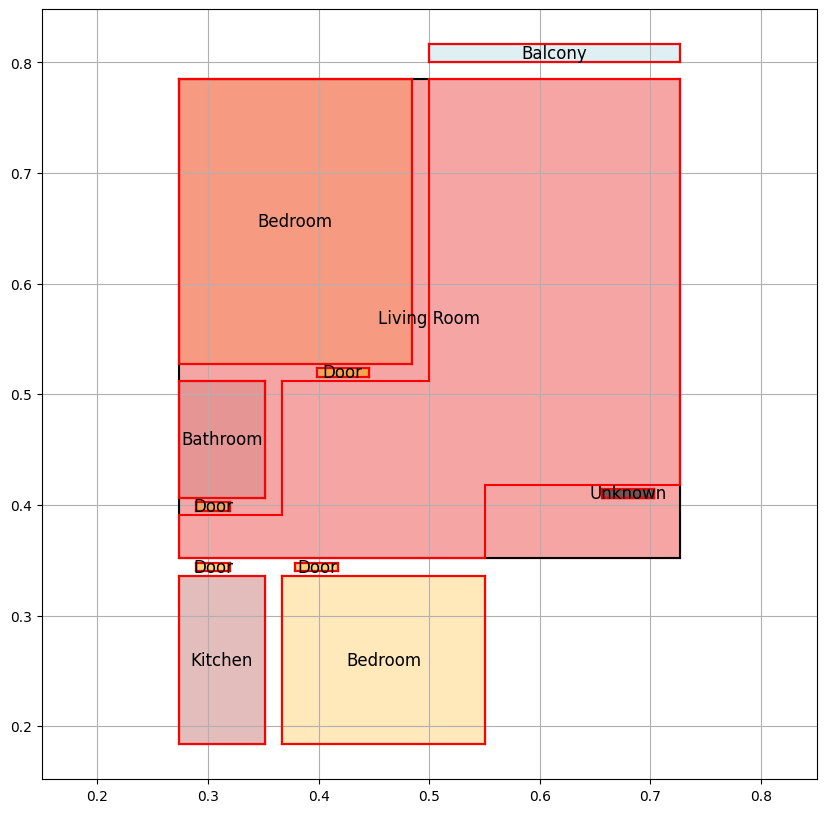

Room Bounding Boxes: [[0.2734375  0.18359375 0.3515625  0.3359375 ]
 [0.2734375  0.40625    0.3515625  0.51171875]
 [0.2734375  0.52734375 0.484375   0.78515625]
 [0.3671875  0.18359375 0.55078125 0.3359375 ]
 [0.5        0.80078125 0.7265625  0.81640625]
 [0.2734375  0.3515625  0.7265625  0.78515625]
 [0.2890625  0.39453125 0.3203125  0.40234375]
 [0.2890625  0.33984375 0.3203125  0.34765625]
 [0.3984375  0.515625   0.4453125  0.5234375 ]
 [0.37890625 0.33984375 0.41796875 0.34765625]
 [0.65625    0.40625    0.703125   0.4140625 ]]
Room Types: [2, 4, 3, 3, 5, 1, 17, 17, 17, 17, 15]
Nodes:      [ 2  4  3  3  5  1 17 17 17 17 15]
Floor Plan Edges: [[ 0 -1  1]
 [ 0 -1  2]
 [ 0 -1  3]
 [ 0 -1  4]
 [ 0  1  5]
 [ 0 -1  6]
 [ 0  1  7]
 [ 0 -1  8]
 [ 0 -1  9]
 [ 0 -1 10]
 [ 1 -1  2]
 [ 1 -1  3]
 [ 1 -1  4]
 [ 1  1  5]
 [ 1  1  6]
 [ 1 -1  7]
 [ 1 -1  8]
 [ 1 -1  9]
 [ 1 -1 10]
 [ 2 -1  3]
 [ 2 -1  4]
 [ 2  1  5]
 [ 2 -1  6]
 [ 2 -1  7]
 [ 2  1  8]
 [ 2 -1  9]
 [ 2 -1 10]
 [ 3 -1  4]
 [ 3  1  

In [13]:
layout = RoomLayout()
rms_type, fp_eds, rms_bbs, eds_to_rms = layout.reader('11.json')
layout.plot_results(rms_type, fp_eds, rms_bbs)

#print("Floor Plan Edges Types:", fp_eds)
print("Room Bounding Boxes:", rms_bbs)

nodes, edges, rms_masks = layout.build_graph(rms_type, fp_eds, eds_to_rms)

print("Room Types:", rms_type)
print("Nodes:     ", nodes)
print("Floor Plan Edges:", edges)
#print("Room Masks:", rms_masks)

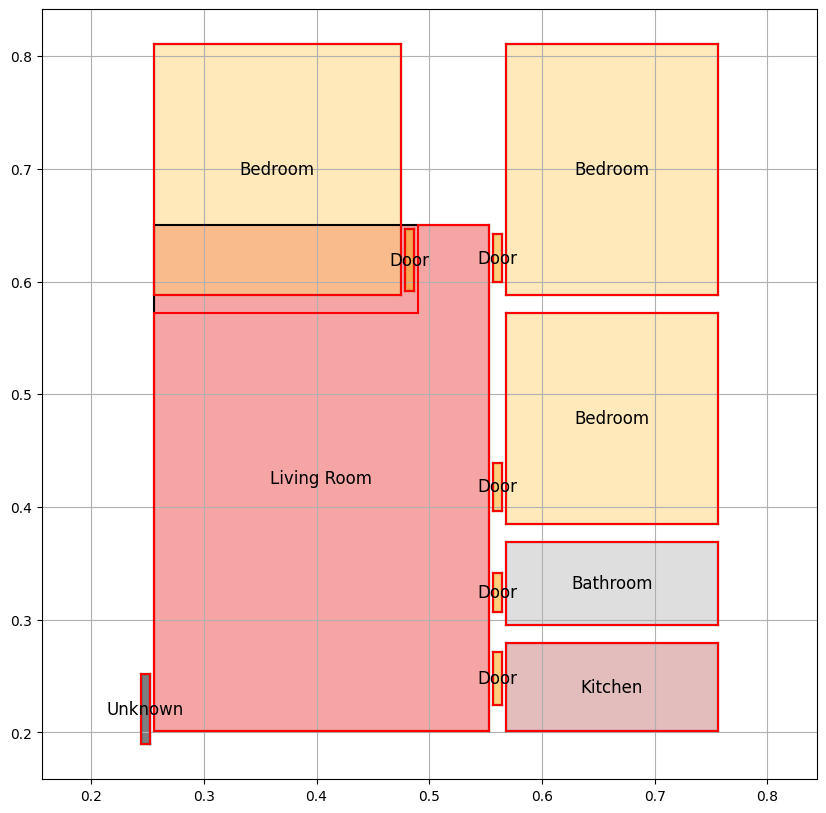

Nodes: [ 1  2  4  3  3  3 17 17 17 17 17 15]


In [4]:
layout = RoomLayout()

# Read data from a JSON file
rms_type, fp_eds, rms_bbs, eds_to_rms = layout.reader('10.json')

# Plot the room layout
layout.plot_results(rms_type, fp_eds, rms_bbs)

# Build the graph
nodes, triples, rms_masks = layout.build_graph(rms_type, fp_eds, eds_to_rms)

print("Nodes:", nodes)
#print("Triples:", triples)
#print("Room Masks:", rms_masks)

### Dictionaries

In [3]:
# Dictionaries for room type to color and room class
ID_COLOR = {1: '#EE4D4D', 2: '#C67C7B', 3: '#FFD274', 4: '#BEBEBE', 5: '#BFE3E8',
            6: '#7BA779', 7: '#E87A90', 8: '#FF8C69', 10: '#1F849B', 11: '#727171',
            13: '#785A67', 12: '#D3A2C7', 17: '#FFA500'}

ROOM_CLASS = {'Living Room': 1, 'Kitchen': 2, 'Bedroom': 3, 'Bathroom': 4, 'Balcony': 5,
    'Entrance': 6, 'Dining Room': 7, 'Study Room': 8, 'Storage': 10, 'Front Door': 11,
    'Unknown': 13, 'Interior Door': 12, 'Door': 17}

ID_TO_ROOM_NAME = {v: k for k, v in ROOM_CLASS.items()}

get_bin = lambda x, z: [int(y) for y in format(x, 'b').zfill(z)]
get_one_hot = lambda x, z: np.eye(z)[x]

subgraphs = []
org_graphs = []
org_houses = []
max_num_points = 100
houses = []
door_masks = []
self_masks = []
gen_masks = []
graphs = []

### Reader function

In [4]:
def reader(filename):
    with open(filename) as f:
        info = json.load(f)
        rms_bbs = np.asarray(info['boxes'])
        fp_eds = info['edges']
        rms_type = info['room_type']
        eds_to_rms = info['ed_rm']
        s_r = 0
        for rmk in range(len(rms_type)):
            if rms_type[rmk] != 17:
                s_r = s_r + 1
        rms_bbs = np.array(rms_bbs) / 256.0
        fp_eds = np.array(fp_eds) / 256.0
        fp_eds = fp_eds[:, :4]
        # extract boundary box and centralize
        tl = np.min(rms_bbs[:, :2], 0)
        br = np.max(rms_bbs[:, 2:], 0)
        shift = (tl + br) / 2.0 - 0.5
        rms_bbs[:, :2] -= shift
        rms_bbs[:, 2:] -= shift
        fp_eds[:, :2] -= shift
        fp_eds[:, 2:] -= shift
        tl -= shift
        br -= shift

    return rms_type, fp_eds, rms_bbs, eds_to_rms

### Plotting Results

In [5]:
def plot_results(rms_type, fp_eds, rms_bbs):
    plt.figure(figsize=(10, 10))

    # Plot room bounding boxes and annotate with room names
    for idx, bbox in enumerate(rms_bbs):
        room_type_id = rms_type[idx]
        room_color = ID_COLOR.get(room_type_id, '#000000')  # Default to black if ID not found
        room_name = ID_TO_ROOM_NAME.get(room_type_id, 'Unknown')

        # Fill the room with the corresponding color
        plt.fill([bbox[0], bbox[2], bbox[2], bbox[0]], [bbox[1], bbox[1], bbox[3], bbox[3]], color=room_color, alpha=0.5)

        # Draw the bounding box
        plt.plot([bbox[0], bbox[2]], [bbox[1], bbox[1]], color='k')
        plt.plot([bbox[0], bbox[2]], [bbox[3], bbox[3]], color='k')
        plt.plot([bbox[0], bbox[0]], [bbox[1], bbox[3]], color='k')
        plt.plot([bbox[2], bbox[2]], [bbox[1], bbox[3]], color='k')

        # Annotate with room name
        plt.text((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2, room_name,
                 horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

    # Plot edges
    for edge in fp_eds:
        plt.plot([edge[0], edge[2]], [edge[1], edge[3]], 'r-')

    plt.grid(True)
    plt.axis('equal')
    plt.show()


### Making seqeuence of Data

In [6]:
def make_sequence(edges):
    polys = []
    v_curr = tuple(edges[0][:2])
    e_ind_curr = 0
    e_visited = [0]
    seq_tracker = [v_curr]

    find_next = False
    while len(e_visited) < len(edges):
        if not find_next:
            if v_curr == tuple(edges[e_ind_curr][2:]):
                v_curr = tuple(edges[e_ind_curr][:2])
            else:
                v_curr = tuple(edges[e_ind_curr][2:])
            find_next = not find_next
        else:
            # look for next edge
            for k, e in enumerate(edges):
                if k not in e_visited:
                    if v_curr == tuple(e[:2]):
                        v_curr = tuple(e[2:])
                        e_ind_curr = k
                        e_visited.append(k)
                        break
                    elif v_curr == tuple(e[2:]):
                        v_curr = tuple(e[:2])
                        e_ind_curr = k
                        e_visited.append(k)
                        break

        # extract next sequence
        if v_curr == seq_tracker[-1]:
            polys.append(seq_tracker)
            for k, e in enumerate(edges):
                if k not in e_visited:
                    v_curr = tuple(edges[0][:2])
                    seq_tracker = [v_curr]
                    find_next = False
                    e_ind_curr = k
                    e_visited.append(k)
                    break
        else:
            seq_tracker.append(v_curr)
    polys.append(seq_tracker)

    return polys

### Building graph

In [7]:
def build_graph(set_name, rms_type, fp_eds, eds_to_rms, out_size=64):
    # create edges
    triples = []
    nodes = rms_type
    # encode connections
    for k in range(len(nodes)):
        for l in range(len(nodes)):
            if l > k:
                is_adjacent = any([True for e_map in eds_to_rms if (l in e_map) and (k in e_map)])
                if is_adjacent:
                    if 'train' in set_name:
                        triples.append([k, 1, l])
                    else:
                        triples.append([k, 1, l])
                else:
                    if 'train' in set_name:
                        triples.append([k, -1, l])
                    else:
                        triples.append([k, -1, l])
    # get rooms masks
    eds_to_rms_tmp = []
    for l in range(len(eds_to_rms)):
        eds_to_rms_tmp.append([eds_to_rms[l][0]])
    rms_masks = []
    im_size = 256
    fp_mk = np.zeros((out_size, out_size))
    for k in range(len(nodes)):
        # add rooms and doors
        eds = []
        for l, e_map in enumerate(eds_to_rms_tmp):
            if (k in e_map):
                eds.append(l)
        # draw rooms
        rm_im = Image.new('L', (im_size, im_size))
        dr = ImageDraw.Draw(rm_im)
        for eds_poly in [eds]:
            poly = make_sequence(np.array([fp_eds[l][:4] for l in eds_poly]))[0]
            poly = [(im_size * x, im_size * y) for x, y in poly]
            if len(poly) >= 2:
                dr.polygon(poly, fill='white')
            else:
                print("Empty room")
                exit(0)
        rm_im = rm_im.resize((out_size, out_size))
        rm_arr = np.array(rm_im)
        inds = np.where(rm_arr > 0)
        rm_arr[inds] = 1.0
        rms_masks.append(rm_arr)
        if rms_type[k] != 15 and rms_type[k] != 17:
            fp_mk[inds] = k + 1
    # trick to remove overlap
    for k in range(len(nodes)):
        if rms_type[k] != 15 and rms_type[k] != 17:
            rm_arr = np.zeros((out_size, out_size))
            inds = np.where(fp_mk == k + 1)
            rm_arr[inds] = 1.0
            rms_masks[k] = rm_arr
    # convert to array
    nodes = np.array(nodes)
    triples = np.array(triples)
    rms_masks = np.array(rms_masks)
    return nodes, triples, rms_masks


### Making Contours and Masks

In [8]:
def contour_masks(graph_edges, rooms_mks, graph_nodes):
    house = []
    for room_mask, room_type in zip(rooms_mks, graph_nodes):
        room_mask = room_mask.astype(np.uint8)
        room_mask = cv.resize(room_mask, (256, 256), interpolation=cv.INTER_AREA)
        contours, _ = cv.findContours(room_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        contours = contours[0]
        house.append([contours[:, 0, :], room_type])
    org_graphs.append(graph_edges)
    org_houses.append(house)

    return org_graphs, org_houses

### Displaying contours and masks

In [9]:
def display_room_mask_and_contours(room_mask, contours):
    # Create a blank image to draw contours
    contour_image = np.zeros_like(room_mask)

    # Draw contours
    cv.drawContours(contour_image, [contours], -1, (255, 255, 255), 1)

    # Stack the room mask and contour image side by side for comparison
    stacked_image = np.hstack((room_mask * 255, contour_image))

    # Display the image
    cv.imshow('Room Mask and Contours', stacked_image)
    cv.waitKey(0)
    cv.destroyAllWindows()

### Data Processing

In [10]:
def data_process(set_name, org_houses, org_graphs):
    if set_name == 'train':
        cnumber_dist = defaultdict(list)
    
    house_layouts = []
    max_num_points = 100
    houses = []
    door_masks = []
    self_masks = []
    gen_masks = []
    graphs = []
    for index, (h, graph) in enumerate(tqdm(zip(org_houses, org_graphs), desc='processing dataset')):
        house = []
        corner_bounds = []
        num_points = 0
        
        for i, room in enumerate(h):
            if room[1] > 10:
                room[1] = {15: 11, 17: 12, 16: 13, 12: 14}.get(room[1], room[1])  # handle all room types above 10
            room[0] = np.reshape(room[0], [len(room[0]), 2]) / 256. - 0.5  # Normalize and map to [-0.5, 0.5]
            room[0] = room[0] * 2  # Map to [-1, 1]
            if set_name == 'train':
                cnumber_dist[room[1]].append(len(room[0]))
                
            # Adding conditions
            num_room_corners = len(room[0])
            rtype = np.repeat(np.array([get_one_hot(room[1], 25)]), num_room_corners, 0)
            room_index = np.repeat(np.array([get_one_hot(len(house) + 1, 32)]), num_room_corners, 0)
            corner_index = np.array([get_one_hot(x, 32) for x in range(num_room_corners)])
            
            # Src_key_padding_mask
            padding_mask = np.repeat(1, num_room_corners).reshape(-1, 1)
            connections = np.array([[i, (i + 1) % num_room_corners] for i in range(num_room_corners)])
            connections += num_points

            # Generating corner bounds for attention masks
            corner_bounds.append([num_points, num_points + num_room_corners])
            num_points += num_room_corners
            room = np.concatenate((room[0], rtype, corner_index, room_index, padding_mask, connections), 1)
            house.append(room)
        
        house = np.concatenate(house, 0)
        
        if len(house_layouts) + len(house) > max_num_points:
            continue
        
        house_layouts.append(house)
    
    house_layouts = np.concatenate(house_layouts, 0)
    
    if len(house_layouts) < max_num_points:
        padding = np.zeros((max_num_points - len(house_layouts), house_layouts.shape[1]))
        house_layouts = np.concatenate((house_layouts, padding), 0)
    
    gen_mask = np.ones((max_num_points, max_num_points))
    gen_mask[:len(house_layouts), :len(house_layouts)] = 0

    door_mask = np.ones((max_num_points, max_num_points))
    self_mask = np.ones((max_num_points, max_num_points))
    self_mask = np.ones((max_num_points, max_num_points))
    for i in range(len(corner_bounds)):
        for j in range(len(corner_bounds)):
            if i == j:
                self_mask[corner_bounds[i][0]:corner_bounds[i][1],
                corner_bounds[j][0]:corner_bounds[j][1]] = 0
            elif any(np.equal([i, 1, j], graph).all(1)) or any(np.equal([j, 1, i], graph).all(1)):
                door_mask[corner_bounds[i][0]:corner_bounds[i][1],
                corner_bounds[j][0]:corner_bounds[j][1]] = 0
    houses.append(house_layouts)
    door_masks.append(door_mask)
    self_masks.append(self_mask)
    gen_masks.append(gen_mask)
    graphs.append(graph)
    num_coords = 2

    return houses, door_masks, self_masks, gen_masks, graphs, num_coords

### Saving through NPZ

In [11]:
def save_data(set_name, graphs, houses, door_masks, self_masks, gen_masks):
    folder_name = "test_saves"
    target_set = 5

    if set_name == 'train':
        cnumber_dist = defaultdict(list)
    # Ensure the directory exists
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Save the main data
    np.savez_compressed(
        f'{folder_name}/rplan_{set_name}_{target_set}',
        graphs=graphs,
        houses=houses,
        door_masks=door_masks,
        self_masks=self_masks,
        gen_masks=gen_masks
    )
    
    # Save the conditional data if it exists
    if set_name == 'train' and cnumber_dist is not None:
        np.savez_compressed(
            f'{folder_name}/rplan_{set_name}_{target_set}_cndist',
            cnumber_dist=cnumber_dist
        )


In [12]:
# Example usage
filename = '11.json'
set_name = 'train'
# Read the data from the file
rms_type, fp_eds, rms_bbs, eds_to_rms = reader(filename)
fp_size = len([x for x in rms_type if x != 15 and x != 17])

graph = [rms_type, rms_bbs, fp_eds, eds_to_rms]

# process the graph data
rms_type = graph[0]
rms_bbs = graph[1]
fp_eds = graph[2]
eds_to_rms = graph[3]  # edges to rooms
rms_bbs = np.array(rms_bbs) # rooms bounding boxes
fp_eds = np.array(fp_eds) # floorplan edges

# build the graph
graph_nodes, graph_edges, rooms_mks = build_graph(set_name, rms_type, fp_eds, eds_to_rms)

# making masks and contours
org_graphs, org_houses = contour_masks(graph_edges, rooms_mks, graph_nodes)

# processing the data
houses, door_masks, self_masks, gen_masks, graphs, num_coords = data_process(set_name, org_houses, org_graphs)

# saving the data
save_data(set_name, graphs, houses, door_masks, self_masks, gen_masks)


# house = []
##### For Displaying the Masks and Contours
# for room_mask, room_type in zip(rooms_mks, graph_nodes):
#     room_mask = room_mask.astype(np.uint8)
#     room_mask_resized = cv.resize(room_mask, (256, 256), interpolation=cv.INTER_AREA)
#     contours, _ = cv.findContours(room_mask_resized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#     if contours:
#         contours = contours[0]
#         house.append([contours[:, 0, :], room_type])
            
#         # Call the function to display room_mask and contours
#         display_room_mask_and_contours(room_mask_resized, contours)

# print("Graph Edges:", graph_edges[:16])
# #print("org_houses:", house)

# print("Organized Graph Edges:", org_graphs[:16])
# #print("org_houses:", org_houses)

processing dataset: 1it [00:00, 33.34it/s]
